# Prédictions : courbes d'apprentissages selon différents modèles et différents paramètres

Afin d'y voir un peu plus clair dans la jungle des paramètres possibles 

 + feature engineering avec différentes échelles
 + différents tactiques d'imputation de données
 + etc
 
 on va tracer des courbes d'apprentissage, afin de sélectionner les meilleures options.

In [99]:
library(here)
setwd(here())
print(getwd())
source(file="misc_functions.R")
source(file="experiments/learning_curve/learning_curve.R")
source(file="experiments/titanic_challenge/1_feature_engineering.R")

library(lattice)
library(gridExtra)
library(mice)

library(randomForest)
library(e1071)

[1] "/home/mathias/ML"


In [105]:
train.raw <- read.csv("datasets/titanic_na/train.csv")

remove.na <- function(df) {
    df$Fare[df$Fare == 0] <- NA
    narows <- is.na(df$Age) | (is.na(df$Fare))
    res <- df[!narows,]
    res$SurvivedF <- as.factor(res$Survived)
    return(res)
}

train.nona <- remove.na(train.raw)


## 1 Fonctions pour différents modèles

Fonction auxilière

In [106]:

features <- c("Pclass", "Sex", "Age", "SibSp", "Parch", "Fare")

discretize <- function(data, threshold=0.5) {
  res <- sapply(data, function(e) {if (e < threshold) {return(0)} else {return(1)}});
  return(res);
}

Régression logistique 

In [107]:
# plusieurs familles, on pourrait les comparer
families <- c( binomial(link = "logit"),
               gaussian(link = "identity"),
               Gamma(link = "inverse"),
               inverse.gaussian(link = "1/mu^2"),
               poisson(link = "log"))

logreg.model_fun <- function(formula, train) {
  return(glm(as.formula(formula), data = train, family = binomial(link = "logit")))
}
logreg.predict_fun <- function(model, data) {
  discretize(plogis(predict(model, data)))
}

logreg.plot <- learning_curve$plot(train.nona, test=0.1, 
                    target = "Survived", features = features,
                    logreg.model_fun, logreg.predict_fun,
                    title = "logistic regression", step = 20)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

In [108]:

svm.linear.model_fun  <- function(formula, train) {
  return(svm(as.formula(formula), 
             data = train, kernel="linear", cost=50, coef0=1,
             type="C-classification"))
}

svm.linear.plot <- learning_curve$plot(train.nona, test = 0.1, 
                                       target = "SurvivedF", features = features, 
                                       svm.linear.model_fun, step=20,
                                        title = "svm linear", previous_plot = logreg.plot)

Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningfu

In [110]:


svm.logi.model_fun  <- function(formula, train) {
  return(svm(as.formula(formula), 
             data = train, kernel="sigmoid",  cost=50, coef0=1,
             type="C-classification"))
}

svm.logi.predict_fun <- function(model, data) {
  discretize(plogis(predict(model, data)))
}
svm.logi.plot <- learning_curve$plot(train.nona, test = 0.1,
                                     target = "SurvivedF", features = features, 
                    svm.logi.model_fun,  step=20,
                    title = "svm sigmoid", previous_plot = svm.linear.plot)

Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningfu

In [113]:

svm.poly.model_fun  <- function(formula, train) {
  return(svm(as.formula(formula), 
             data = train, kernel="polynomial", degree=3, cost=50, coef0=1,
             type="C-classification"))
}

svm.poly.plot <- learning_curve$plot(train.nona, test = 0.1,
                                     target = "SurvivedF", features = features,  
                                     svm.poly.model_fun, step=20,
                    title = "svm polynomial", previous_plot = svm.logi.plot)



Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningfu

In [114]:

rf.model_fun <- function(formula, train) {
  randomForest(as.formula(formula), 
               data = train, na.action = na.roughfix, type="classification")
}

rf.plot <- learning_curve$plot(train.nona, test = 0.1,
                               target = "SurvivedF", features = features,  
                               rf.model_fun, step=20,
                               title = "random forest", previous_plot = svm.poly.plot)

Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘>=’ not meaningful for factors”Warning message in Ops.factor(bin.pred, threshold):
“‘<’ not meaningfu

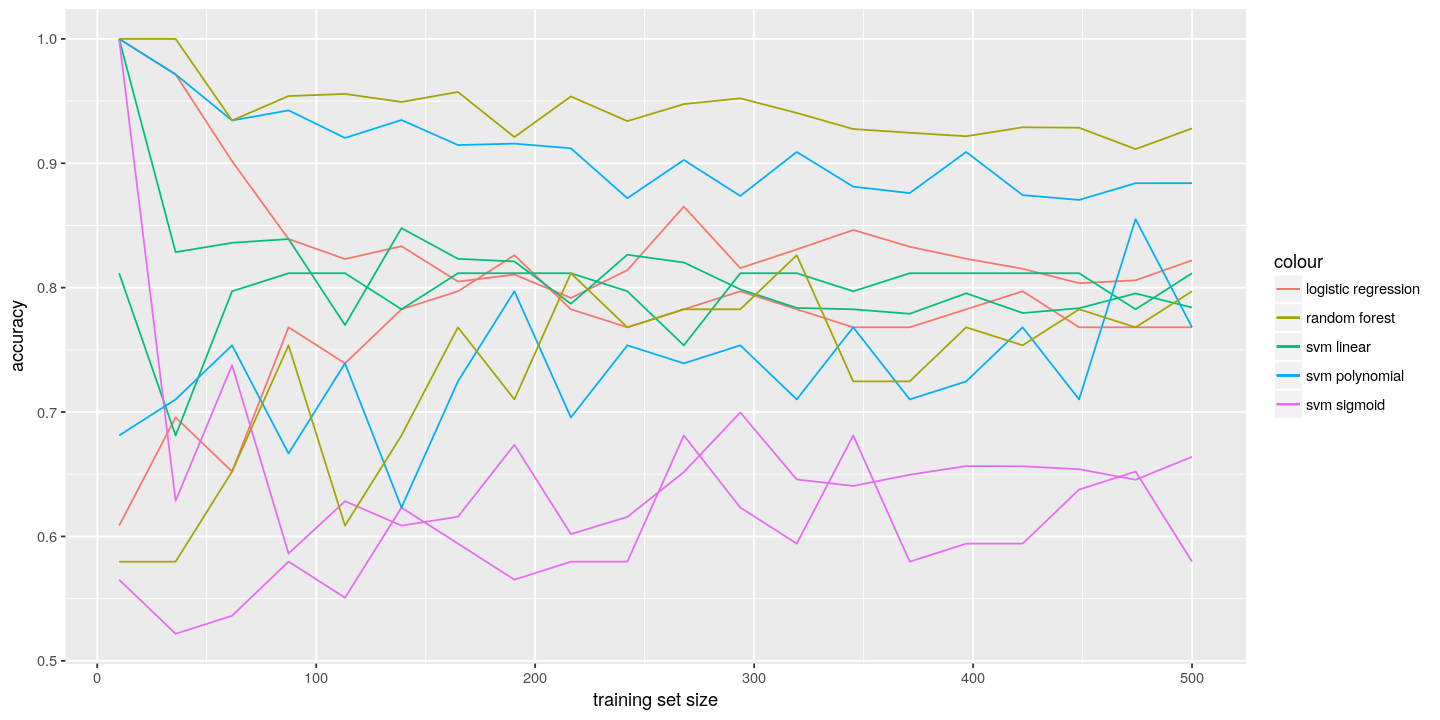

In [117]:
options(repr.plot.height= 6,repr.plot.width= 12)
print(rf.plot)